In [1]:
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import transformer_lens
import transformer_lens.utils as utils
import circuitsvis as cv
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import json
import random
from tqdm import tqdm as tqdm
import plotly.express as px
import pandas as pd
from fancy_einsum import einsum
from functools import partial
from prompts_to_df import convert_strs_to_df
from collections import Counter
from typing import List

def imshow(tensor, renderer=None, midpoint=0, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=midpoint, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [5]:
torch.set_grad_enabled(False)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_name = 'gpt2-medium'
model = HookedTransformer.from_pretrained(
    model_name,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    device = device
)
print("device:", device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
device: cuda:0


In [6]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]

    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

In [7]:
from torch.utils.data import DataLoader, Dataset

class ObjectData(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def __len__(self):
        return len(self.data)

with open("data/good_data_42.json", 'r') as fp:#"data/good_data_42.json" #data/gpt2-medium_incorrect_42.json
    clean_data = json.load(fp)
cleand, cleanlabs = [i[0] for i in clean_data], [i[1] for i in clean_data]
batch_size = 1
clean_loader = DataLoader(ObjectData(cleand, cleanlabs), batch_size=batch_size, shuffle=False)

In [8]:
def patch_head_vector_at_pos(
    clean_head_vector,
    hook,
    head_index,
    dest_index,
    source_idxs):
    clean_head_vector[:, head_index, dest_index, :] = 0
    clean_head_vector[:, head_index, dest_index, source_idxs] = 1/len(source_idxs)
    return clean_head_vector

def head_ablation_hook(
    value,
    hook,
    head_index
):
    value[:, :, head_index, :] = 0.
    return value

def patch_attn_input(clean_input, hook, head_index, pos_index, additive_patch):
    #print("CLEAN", clean_input.shape, flush=True)
    clean_input[:, pos_index,head_index, :] +=additive_patch #additive_patch should be shape head_dim
    return clean_input

In [9]:
def get_headout_sum(cld, cll):
    
    str_toks = model.to_str_tokens(cld[0], prepend_bos=False)
    #print(str_toks)
    ans_idx = str_toks.index(cll[0].lower())
    example_label_idx = 30
    color_idxs = [43-2, 47-2, 52-2]
    color_idxs.remove(ans_idx)
    
    model.reset_hooks()

    hook_fn = partial(patch_head_vector_at_pos, head_index=4, dest_index = -1, source_idxs=color_idxs)
    model.blocks[6].attn.hook_pattern.add_hook(hook_fn)

    hook_fn = partial(patch_head_vector_at_pos, head_index=15, dest_index = -1, source_idxs=[c+1 for c in color_idxs])
    model.blocks[6].attn.hook_pattern.add_hook(hook_fn)

    hook_fn = partial(patch_head_vector_at_pos, head_index=2, dest_index = -1, source_idxs=[c+1 for c in color_idxs])
    model.blocks[7].attn.hook_pattern.add_hook(hook_fn)

    hook_fn = partial(patch_head_vector_at_pos, head_index=11, dest_index = -1, source_idxs=color_idxs)
    model.blocks[7].attn.hook_pattern.add_hook(hook_fn)

    hook_fn = partial(patch_head_vector_at_pos, head_index=15, dest_index = -1, source_idxs=color_idxs)
    model.blocks[8].attn.hook_pattern.add_hook(hook_fn)

    hook_fn = partial(patch_head_vector_at_pos, head_index=3, dest_index = -1, source_idxs=[c+1 for c in color_idxs])
    model.blocks[9].attn.hook_pattern.add_hook(hook_fn)

    logits, cache = model.run_with_cache(cleand[0])
    model.reset_hooks()
    
    headouts, labels = cache.stack_head_results(pos_slice=-1, return_labels=True)
    head_labels = ['L6H4', 'L6H15', "L7H2", "L7H11", "L8H15", "L9H3"]
    print(headouts.shape)
    headout_sum = torch.zeros_like(headouts[0, 0])
    for label in head_labels:
        label_idx = labels.index(label)
        headout_sum+=headouts[label_idx, 0]
    return headout_sum

In [10]:
def null_intervention(model, color_idxs):
    pass

def inhibition_intervention(model, color_idxs):
    #inhibition heads
    hook_fn = partial(patch_head_vector_at_pos, head_index=3, dest_index = -1, source_idxs=color_idxs)
    model.blocks[12].attn.hook_pattern.add_hook(hook_fn)

    hook_fn = partial(patch_head_vector_at_pos, head_index=13, dest_index = -1, source_idxs=color_idxs)
    model.blocks[13].attn.hook_pattern.add_hook(hook_fn)

    hook_fn = partial(patch_head_vector_at_pos, head_index=4, dest_index = -1, source_idxs=color_idxs)
    model.blocks[13].attn.hook_pattern.add_hook(hook_fn)


def neg_mover_intervention(model, color_idxs):
    #anti copying head        
    hook_fn = partial(patch_head_vector_at_pos, head_index=1, dest_index = -1, source_idxs=color_idxs)
    model.blocks[19].attn.hook_pattern.add_hook(hook_fn)

def content_gatherer_intervention(model, color_idxs):
    #content gatherer heads
    hook_fn = partial(head_ablation_hook, head_index=6)
    model.blocks[11].attn.hook_v.add_hook(hook_fn)

    hook_fn = partial(head_ablation_hook, head_index=7)
    model.blocks[11].attn.hook_v.add_hook(hook_fn)

    hook_fn = partial(head_ablation_hook, head_index=15)
    model.blocks[12].attn.hook_v.add_hook(hook_fn)


def run_model(model, clean_loader, interventions: List):
    correct = 0
    total = 0
    correct_inputs= []
    wrong_inputs = []

    correct_idxs = []
    wrong_idxs = []

    interv=False #unused in this version

    for cld, cll in tqdm(clean_loader):
        model.reset_hooks()
        #cleanbatch = clean_loader[0
        #corrbatch = corr_loader[0]
        ans_tokens = []
        for cl in cll:
            #print('cl1', cl, 'c01', co)
            ans_tokens.append( torch.tensor(model.to_single_token(cl)))
        ans_tokens = torch.stack(ans_tokens).to(device)
        str_toks = model.to_str_tokens(cld[0], prepend_bos=False)
        #print(str_toks)
        ans_idx = str_toks.index(cll[0].lower())
        example_label_idx = 31-1
        color_idxs = [43-2, 47-2, 52-2]
        color_idxs.remove(ans_idx)
        #print([f'{k}_{s}' for k,s in enumerate(str_toks)])
        #break
        for intervention in interventions:
            intervention(model, color_idxs)
        if interv:
            pass
            
            

        cl_tokens = model.to_tokens(cld, prepend_bos=False)
        logits, cache=model.run_with_cache(cl_tokens)
        #print(logits.shape)
        preds = logits[:, -1].argmax(dim=-1)
        #print(preds.shape)
        for i,(pred, lab) in enumerate(zip(preds, ans_tokens)):
            if pred.item() == lab.item():
                correct+=1
                correct_idxs.append((cld[i], cll[i]))
                correct_inputs.append((cld[i], cll[i]))
            else:
                wrong_inputs.append((cld[i], model.tokenizer.decode(pred.detach().cpu().item())))
                wrong_idxs.append((cld[i], cll[i]))
            total+=1
        #if total==100:
        #    break
    return (correct, total, list(correct_idxs), list(wrong_idxs), list(correct_inputs), list(wrong_inputs))

In [16]:
def run_vanilla(model: HookedTransformer, clean_loader: ObjectData):
    interventions = []
    correct, total, correct_idxs, wrong_idxs, correct_inputs, wrong_inputs = run_model(model,
                                                                                    clean_loader, 
                                                                                    interventions)
    print(correct, total, correct/total)
    return correct_idxs, wrong_idxs, correct_inputs, wrong_inputs

def run_inhib_only(model: HookedTransformer, clean_loader: ObjectData):
    interventions = [inhibition_intervention]
    correct, total, correct_idxs, wrong_idxs, correct_inputs, wrong_inputs = run_model(model, 
                                                                                    clean_loader, 
                                                                                    interventions)
    print(correct, total, correct/total)
    return correct_idxs, wrong_idxs, correct_inputs, wrong_inputs

#@step(name="neg_mover_only_interv", deterministic=True, cacheable=True)
def run_neg_mover_only(model: HookedTransformer, clean_loader: ObjectData):
    interventions = [neg_mover_intervention]
    correct, total, correct_idxs, wrong_idxs, correct_inputs, wrong_inputs = run_model(model, 
                                                                                    clean_loader, 
                                                                                    interventions)
    print(correct, total, correct/total)
    return correct_idxs, wrong_idxs, correct_inputs, wrong_inputs

#@step(name="inhib_and_neg_mover_interv", deterministic=True, cacheable=True)
def run_inhib_and_neg_mover(model: HookedTransformer, clean_loader: ObjectData):
    interventions = [inhibition_intervention, neg_mover_intervention]
    correct, total, correct_idxs, wrong_idxs, correct_inputs, wrong_inputs = run_model(model, 
                                                                                    clean_loader, 
                                                                                    interventions)
    print(correct, total, correct/total)
    return correct_idxs, wrong_idxs, correct_inputs, wrong_inputs

In [13]:
van_correct, van_wrong_idxs, van_correct, van_wrong = run_vanilla(model, clean_loader)


Intervention? False


100%|██████████| 1000/1000 [00:52<00:00, 18.93it/s]

496 1000 0.496


In [17]:
inhib_interv_correct_idxs, inhib_interv_wrong_idxs, inhib_interv_correct, inhib_interv_wrong = run_inhib_only(model, clean_loader)
neg_interv_correct_idxs, neg_interv_wrong_idxs, neg_interv_correct, neg_interv_wrong = run_neg_mover_only(model, clean_loader)




Intervention? False


100%|██████████| 1000/1000 [00:53<00:00, 18.65it/s]


815 1000 0.815
Intervention? False


100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]

781 1000 0.781


In [18]:
full_interv_correct_idxs, full_interv_wrong_idxs, full_interv_correct, full_interv_wrong = run_inhib_and_neg_mover(model, clean_loader)



Intervention? False


100%|██████████| 1000/1000 [00:53<00:00, 18.59it/s]

937 1000 0.937


496
815


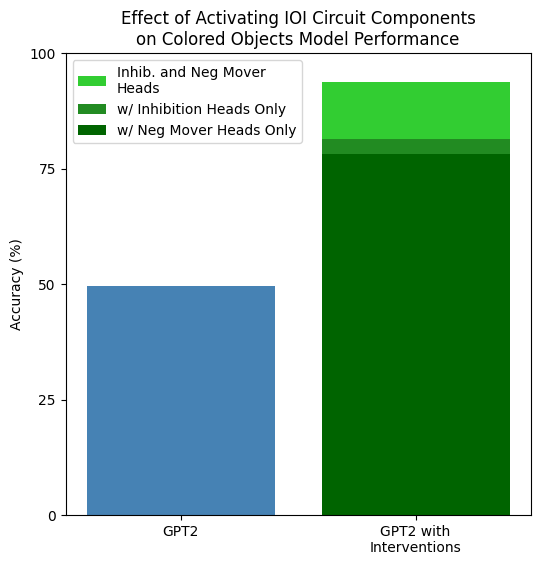

In [22]:
total = 1000
baseline_correct = len(van_correct)
print(baseline_correct)
inhib_only_correct = len(inhib_interv_correct)
print(inhib_only_correct)
num_full_interv_correct = len(full_interv_correct)
num_neg_mov_only_correct = len(neg_interv_correct_idxs)

plt.figure(figsize=(6,6))
plt.bar([0], [baseline_correct/total], color='steelblue')
plt.bar([1], [num_full_interv_correct/total], color='limegreen', label='Inhib. and Neg Mover\nHeads')
plt.bar([1], [inhib_only_correct/total], color='forestgreen', label='w/ Inhibition Heads Only')
plt.bar([1], [num_neg_mov_only_correct/total], color='darkgreen', label='w/ Neg Mover Heads Only')

plt.xticks([0,1], ['GPT2', 'GPT2 with\nInterventions'])
plt.legend(loc='upper left')
plt.ylabel("Accuracy (%)")
plt.title("Effect of Activating IOI Circuit Components\non Colored Objects Model Performance")
plt.yticks([0,.25,.5,.75,1.,],[0,25,50,75,100])
plt.savefig("results/gpt2medium_manual_interv_no_cont_accuracy.pdf")